# 2.1.1 Preconditioners in NGSolve

Preconditioners are approximate inverses which are used within iterative methods to solve linear or non-linear equations.

Here are some built-in preconditioners in NGSolve:

* Jacobi and Block-Jacobi
* Direct solvers, i.e. sparse factorization
* Multigrid with different block-smoothers
* p-version element-level BDDC

This tutorial quickly introduces how to use these within a solver. (In later tutorials, we will see how to measure condition numbers and customize preconditioners.)

In [1]:
from netgen.csg import unit_cube
from netgen.geom2d import unit_square
from ngsolve import *
import netgen.gui
%gui tk
import matplotlib.pyplot as plt

### A simple test problem 

We define a simple Poisson problem solver with the name of a preconditioner as argument in order to experiment with preconditioners.


In [2]:
def SolveProblem(h=0.5, p=1, levels=1, 
                 condense = False,
                 precond="local"):
    """
    Solve Poisson problem on l refinement levels.
        h: coarse mesh size
        p: polynomial degree 
        l: number of refinement levels
        precond: name of a built-in preconditioner
        condense: if true, perform static condensations
    OUTPUT: 
        List of tuples of ndofs and iterations
    """
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    # mesh = Mesh(unit_cube.GenerateMesh(maxh=h))
    fes = H1(mesh, order=p, dirichlet="bottom|left")
    
    u, v = fes.TnT() 
    a = BilinearForm(fes, eliminate_internal=condense)
    a += SymbolicBFI(grad(u)*(grad(v)))
    f = LinearForm(fes)
    f += SymbolicLFI(1*v)
    gfu = GridFunction(fes)
    Draw (gfu)
    c = Preconditioner(a, precond) # 'Register' c to a BEFORE assembly

    steps = []
    
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        a.Assemble()
        f.Assemble()
        gfu.Update()

        # Conjugate gradient solver
        inv = CGSolver(a.mat, c.mat, maxsteps=1000)

        # Solve steps depend on condense 
        if condense:
            f.vec.data += a.harmonic_extension_trans * f.vec
        gfu.vec.data = inv * f.vec
        if condense:
            gfu.vec.data += a.harmonic_extension * gfu.vec
            gfu.vec.data += a.inner_solve * f.vec
        steps.append ( (fes.ndof, inv.GetSteps()) )
        Redraw ()
    return steps

The `Preconditioner` registers itself to the `BilinearForm`. Whenever the `BilinearForm` is re-assembled, the `Preconditioner` is updated as well.

### The `local` preconditioner 

The `local` preconditioner is a simple Jacobi preconditioner. 
The number of CG-iterations with the local preconditioner is proportional to $h^{-1} \sim 2^l$:


In [3]:
SolveProblem(precond="local")

[(8, 4)]

In [4]:
res_local = SolveProblem(levels=8, precond="local")
res_local

[(8, 4),
 (21, 9),
 (65, 25),
 (225, 51),
 (833, 103),
 (3201, 208),
 (12545, 418),
 (49665, 842)]

### Multigrid preconditioner 

A geometric multigrid `Preconditioner` uses the sequence of refined meshes to define a preconditioner of optimal iteration number (and complexity as well). It uses a direct solve on the coarsest level, and block Gauss-Seidel smoothers on the refined levels

In [5]:
res_mg = SolveProblem(levels=8, precond="multigrid")
res_mg

[(8, 2),
 (21, 4),
 (65, 7),
 (225, 8),
 (833, 8),
 (3201, 8),
 (12545, 8),
 (49665, 8)]

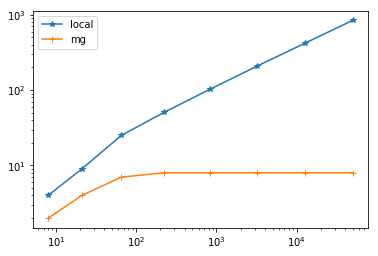

In [6]:
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*res_local), "-*")
plt.plot(*zip(*res_mg), "-+")
plt.legend(['local', 'mg'])
plt.show()

###  Multigrid implementation for higher order spaces 

For high order elements we use hierarchical spaces, where the (small) sub-spaces $V_E$, $V_F$, and $V_C$ are generated by basis functions associated with edges, faces, and cells:

$$
V_{hp} = V_{p=1} + \sum_{\text{edges }E} V_E + \sum_{\text{faces }F} V_F + \sum_{\text{cells }C} V_C
$$

The system matrix is stored as

$$
A = \left( \begin{array}{cccc}
A_{VV} & A_{VE} & A_{VF} & A_{VC} \\
A_{EV} & A_{EE} & A_{EF} & A_{EC} \\
A_{FV} & A_{FE} & A_{FF} & A_{FC} \\
A_{CV} & A_{CE} & A_{CF} & A_{CC} \\
\end{array} \right)
$$

The $A_{VV}$-block is exactly the system matrix of a lowest order method. 

NGSolve's *multigrid implementation for a high order method uses h-version multigrid for the lowest order block,* and  local block-smoothing for the high order bubble basis functions.

In [7]:
for p in range(1,10):
    r = SolveProblem(h=0.5, p=p, levels=4, condense=False, 
                     precond="multigrid")
    print ("p =",p,", res =",r)

p = 1 , res = [(8, 2), (21, 4), (65, 7), (225, 8)]
p = 2 , res = [(21, 5), (65, 6), (225, 8), (833, 8)]
p = 3 , res = [(40, 9), (133, 12), (481, 12), (1825, 13)]
p = 4 , res = [(65, 12), (225, 15), (833, 16), (3201, 16)]
p = 5 , res = [(96, 14), (341, 19), (1281, 20), (4961, 20)]
p = 6 , res = [(133, 16), (481, 23), (1825, 23), (7105, 23)]
p = 7 , res = [(176, 18), (645, 25), (2465, 26), (9633, 26)]
p = 8 , res = [(225, 19), (833, 27), (3201, 28), (12545, 28)]
p = 9 , res = [(280, 20), (1045, 29), (4033, 30), (15841, 30)]


We observe that the number of iterations grows mildly with the order, and remains bounded with mesh refinement.

Performing static condensation improves the situation:

In [8]:
for p in range(1,10):
    r = SolveProblem(h=0.5, p=p, levels=4, condense=True, 
                     precond="multigrid")
    print ("p =",p,", res =",r)

p = 1 , res = [(8, 2), (21, 4), (65, 7), (225, 8)]
p = 2 , res = [(21, 5), (65, 6), (225, 8), (833, 8)]
p = 3 , res = [(40, 5), (133, 6), (481, 7), (1825, 8)]
p = 4 , res = [(65, 5), (225, 6), (833, 7), (3201, 8)]
p = 5 , res = [(96, 5), (341, 6), (1281, 7), (4961, 8)]
p = 6 , res = [(133, 5), (481, 6), (1825, 7), (7105, 8)]
p = 7 , res = [(176, 5), (645, 6), (2465, 7), (9633, 8)]
p = 8 , res = [(225, 5), (833, 6), (3201, 7), (12545, 8)]
p = 9 , res = [(280, 5), (1045, 6), (4033, 7), (15841, 8)]


### Element-wise BDDC preconditioner

A built-in element-wise BDDC (**B**alancing **D**omain **D**ecomposition preconditioner with **C**onstraints) preconditioner is also available. In contrast to local or multigrid preconditioners, the BDDC preconditioner needs access to the element matrices. This is exactly the reason why we register the preconditioner with the `BilinerForm`, and call the `bfa.Assemble()` later.

In [9]:
for p in range(1,10):
    r = SolveProblem(h=0.25, p=p, levels=3, condense=True, 
                     precond="bddc")
    print ("p =",p,", res =",r)

p = 1 , res = [(27, 2), (89, 2), (321, 2)]
p = 2 , res = [(89, 14), (321, 19), (1217, 20)]
p = 3 , res = [(187, 18), (697, 23), (2689, 24)]
p = 4 , res = [(321, 21), (1217, 28), (4737, 29)]
p = 5 , res = [(491, 23), (1881, 31), (7361, 32)]
p = 6 , res = [(697, 25), (2689, 34), (10561, 35)]
p = 7 , res = [(939, 27), (3641, 36), (14337, 37)]
p = 8 , res = [(1217, 28), (4737, 38), (18689, 40)]
p = 9 , res = [(1531, 29), (5977, 39), (23617, 41)]


The BDDC preconditioner needs more iterations, but the work per iteration is less, so performance is similar to multigrid. **This element-wise BDDC preconditioner works well in shared memory parallel as well as in distributed memory mode.** Go to $\S$[2.1.3](../unit-2.1.3-bddc/bddc.ipynb) for more about BDDC preconditioner. 